<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/orderml

/content/drive/My Drive/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder.



In [ ]:
ls

logs/  models/  orderparams.ipynb  OrderPresentation.gslides


Install non-default packages here.

In [3]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 2.8MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=86155fccefe512b390a7ff0f3bad442cb6c5b44ac6300ea99ed7351c89c3222e
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 2.7MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" important methods.

In [9]:
class OrderMethods():

    def bsol(temp,p):
        Tn,Jt,Nf,Bk=p
        t=4.0*(Jt/(Jt+1.0))*Tn/temp
        if (Tn<=0) or (Jt<=0) or temp>=Tn:
            xout=0.0
        else:
            xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

        return xout


    def bfun(x,T,p):
        Tn,Jt,Nf,Bk=p
        if x==0.0:
            B=-1.0 # so that it wont find solution at zero
        else:
            B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
        return B

    def brill(j,x):
        temp=(2*j+1.0)/2/j
        if x==0:
            Br=0.0
        else:
            Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
        return Br

    def Intensity(T,p):
        Tn,Jt,Nf,Bk=p
        br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
        bout=Bk+Nf*br**2
        return bout

    def orderparameter(T, Tn, Jt, Nf, Bk):
        p=[Tn, Jt, Nf, Bk]
        I=[]
        for t in T:
            I.append(OrderMethods.Intensity(t,p))
        return np.array(I)

    def fit(model):
        nllfs = []
        zin = []
        for tns in np.arange(50,200, 5):
            #print("zs", zs)
            model.Tn.value = tns
            model.update()
            schi=model.nllf()
            nllfs.append(schi)
            zin.append(tns)
        plt.scatter(zin, nllfs)
        plt.xlabel("tn in")
        plt.ylabel("chi") 
        plt.show()
        plt.close()

        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [6]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym

class OrderEnv(gym.Env):

    def __init__(self):
        self.reward_scale = 100
        self.episodeNum = 0
        self.steps = 0
        self.T = np.array([])
        self.Bk = .3
        self.error = []

        self.fixedTn = 160
        self.fixedNf = 330
        self.fixedJt = .885

        # self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        # self.action_space = spaces.Box(low = np.array([3]), high = np.array([340]))
        self.action_space = spaces.Discrete(7)
        self.action_options = [1, 5, 10, 15, 20, 25, 30]
        self.curTemp = 3
        self.x = 150 #startTn value

        #logging arrays and vars
        self.rewards = [] #interepisodic
        self.chisqds = []
        self.transTemps = []
        self.Jts = []
        self.Nfs = []
        self.totReward = 0 
        self.info = {}     

    def step(self, action): 
        
        print("stepping: ", self.episodeNum)
        print("ACTION            : ", action)

        self.curTemp += self.action_options[action]
        #self.curTemp = action
        self.curTemp = self.round_to(self.curTemp, 0.5)
        print("curtemp: ", self.curTemp)

        self.steps += 1
        reward = -self.reward_scale
        self.T = np.append(self.T, self.curTemp)
        print("Temperature: ", self.T)
        
        if self.steps > 3:
            self.I = self.getData(self.T, self.Bk)
            #self.I = OrderMethods.getData(self.T, self.Bk)
            print("Intensity: ", self.I)
            self.error= np.sqrt(self.I)
            M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Tn = 200 Jt = .2, Nf = 216, Bk = self.Bk)
            M.Tn.range(10, 400)
            M.Jt.range(0.4, 2)
            M.Nf.range(100,500)

            #this is all for the chi surface graph
            # Mcopy = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Jt = .2, Nf = 216, Bk = self.Bk)
            # Mcopy.Tn.range(10, 400)
            # Mcopy.Jt.range(0.4, 2)
            # Mcopy.Nf.range(100,500)
            # nllfs = []
            # zin = []
            # for tns in np.arange(50,200, 5):
            #     #print("zs", zs)
            #     Mcopy.Tn.value = tns
            #     Mcopy.update()
            #     schi=Mcopy.nllf()
            #     nllfs.append(schi)
            #     zin.append(tns)
            # plt.scatter(zin, nllfs)
            # plt.xlabel("tn in")
            # plt.ylabel("chi") 
            # plt.show()
            # plt.close()

            self.x, dx, chisq, params = OrderMethods.fit(M)
            self.Nf = self.x[1]
            self.Jt = self.x[0]
            self.x = self.x[2]
            print("ORDER PARAM RESULT (X2):", self.x)
            print("THE JT RESULT {X0}:", self.Jt)
            print("THE NF RESULT {X1}:", self.Nf)

            dx = params[0].dx

            print("chisqds: ", chisq)
            print("BUT ARE WE SURE?:", dx)

            plt.plot(self.T, self.I, 'ro')
            plt.show()
            plt.close()

            # if(action > 0.5):
            #   reward += 1000

            if chisq < 2 :
                  reward += 100

            self.chisqds.append(chisq)
            self.transTemps.append(self.x)
            self.Jts.append(self.Jt)
            self.Nfs.append(self.Nf)

        print("highHIIIIGHHHHHH: ", (340-self.curTemp))
        print("rewaRD:: ", reward)

        self.totReward += reward
        self.state = np.array([self.curTemp])
        delta = abs(340 - self.curTemp)

        if (self.steps > 3 and chisq < 0.05 and dx < 10000000): #less than or equal to?
            reward += 200
            print("terminated: excellent conditions")
            terminal = True
            self.log()

        elif (self.curTemp >= 340):
            print("terminated: over max temp")
            terminal = True
            self.log()
        elif (self.steps > 100):
            print("terminated: too long")
            terminal = True
            self.log()
        else:
            terminal = False
        
        print("returned state:", self.state)
        o = self.observation_space 
        print("observation space: ", o.shape)
        return self.state, reward, terminal, self.info


    def reset(self):
        print("reset")
        self.steps = 0
        self.T = np.array([])
        self.I = []
        self.chisqds = []
        self.transTemps = []
        self.Jts = []
        self.Nfs = []
        self.totReward = 0
        self.curTemp = 3
        self.state = np.array([self.curTemp])

        return self.state #starting state

    def log(self):
        self.episodeNum += 1

        filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.chisqds)

        filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.transTemps)

        filename = "logs/jt/jtLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.Jts)

        filename = "logs/nf/nfLog-" + str(self.episodeNum) + ".npy"
        np.savetxt(filename, self.Nfs)

        self.rewards.append(self.totReward)
        filename = "logs/runrewards.npy"
        np.savetxt(filename, self.rewards)

    # @property
    # def action_space(self):
    #     return spaces.Box(low = np.array([0.5]), high = np.array([340 - self.curTemp]))
    #     # return spaces.Box(low = np.array([self.curTemp + 0.5]), high = np.array([340]))

    @property 
    def observation_space(self):
        return spaces.Box(low=3.0, high=340.0, shape=(self.steps + 1,), dtype=np.float32)

    def round_to(self, n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def getData(self, T, Bk):
        return OrderMethods.orderparameter(T, self.fixedTn, self.fixedJt, self.fixedNf, Bk)

    def setTn(self, Tn):
        self.fixedTn = Tn
    
    def setNf(self, Nf):
        self.fixedNf = Nf

    def setJt(self, Jt):
        self.fixedJt = Jt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

reset
stepping:  0
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
stepping:  0
ACTION            :  3
curtemp:  48.0
Temperature:  [33. 48.]
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
returned state: [48.]
observation space:  (3,)
stepping:  0
ACTION            :  3
curtemp:  63.0
Temperature:  [33. 48. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (4,)
stepping:  0
ACTION            :  5
curtemp:  88.0
Temperature:  [33. 48. 63. 88.]
Intensity:  [329.96643649 326.47253736 315.89652018 277.33554

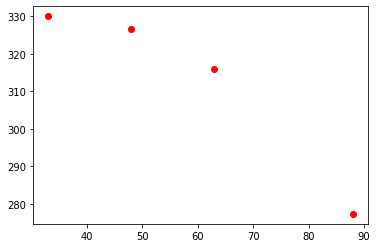

highHIIIIGHHHHHH:  252.0
rewaRD::  -100
returned state: [88.]
observation space:  (5,)
stepping:  0
ACTION            :  5
curtemp:  113.0
Temperature:  [ 33.  48.  63.  88. 113.]
Intensity:  [329.96643649 326.47253736 315.89652018 277.33554063 209.85565285]
ORDER PARAM RESULT (X2): 150.15638332160427
THE JT RESULT {X0}: 0.4000004129617499
THE NF RESULT {X1}: 216.32836109202563
chisqds:  86.48123781874942
BUT ARE WE SURE?: 1.8955101243159882


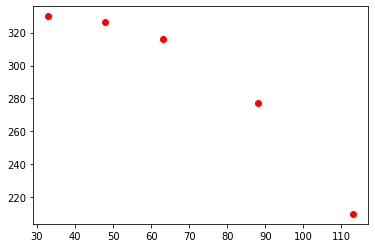

highHIIIIGHHHHHH:  227.0
rewaRD::  -100
returned state: [113.]
observation space:  (6,)
stepping:  0
ACTION            :  6
curtemp:  143.0
Temperature:  [ 33.  48.  63.  88. 113. 143.]
Intensity:  [329.96643649 326.47253736 315.89652018 277.33554063 209.85565285
  88.79189244]
ORDER PARAM RESULT (X2): 151.228751826278
THE JT RESULT {X0}: 0.40000084420339077
THE NF RESULT {X1}: 223.7281176104805
chisqds:  60.03910370214968
BUT ARE WE SURE?: 0.7376558182026108


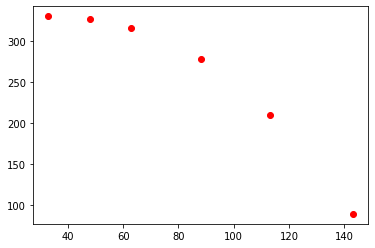

highHIIIIGHHHHHH:  197.0
rewaRD::  -100
returned state: [143.]
observation space:  (7,)
stepping:  0
ACTION            :  3
curtemp:  158.0
Temperature:  [ 33.  48.  63.  88. 113. 143. 158.]
Intensity:  [329.96643649 326.47253736 315.89652018 277.33554063 209.85565285
  88.79189244  11.46559061]
ORDER PARAM RESULT (X2): 151.1796535429428
THE JT RESULT {X0}: 0.4000013194248588
THE NF RESULT {X1}: 223.40929939312684
chisqds:  48.07202918442545
BUT ARE WE SURE?: 0.738077841709117


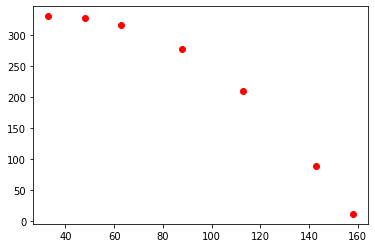

highHIIIIGHHHHHH:  182.0
rewaRD::  -100
returned state: [158.]
observation space:  (8,)
stepping:  0
ACTION            :  4
curtemp:  178.0
Temperature:  [ 33.  48.  63.  88. 113. 143. 158. 178.]
Intensity:  [3.29966436e+02 3.26472537e+02 3.15896520e+02 2.77335541e+02
 2.09855653e+02 8.87918924e+01 1.14655906e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 151.35324635345148
THE JT RESULT {X0}: 0.40000010791400037
THE NF RESULT {X1}: 224.51403790957585
chisqds:  37.557530376663706
BUT ARE WE SURE?: 0.7366670822321268


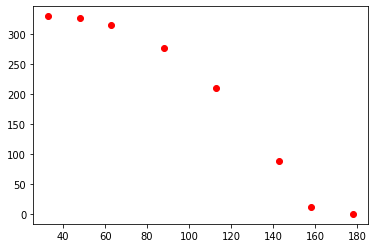

highHIIIIGHHHHHH:  162.0
rewaRD::  -100
returned state: [178.]
observation space:  (9,)
stepping:  0
ACTION            :  2
curtemp:  188.0
Temperature:  [ 33.  48.  63.  88. 113. 143. 158. 178. 188.]
Intensity:  [3.29966436e+02 3.26472537e+02 3.15896520e+02 2.77335541e+02
 2.09855653e+02 8.87918924e+01 1.14655906e+01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 151.53484276642882
THE JT RESULT {X0}: 0.4000003955649994
THE NF RESULT {X1}: 225.66438868419678
chisqds:  30.52521570271971
BUT ARE WE SURE?: 0.7352299773249413


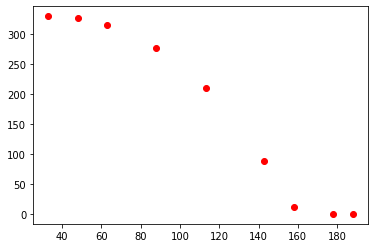

highHIIIIGHHHHHH:  152.0
rewaRD::  -100
returned state: [188.]
observation space:  (10,)
stepping:  0
ACTION            :  2
curtemp:  198.0
Temperature:  [ 33.  48.  63.  88. 113. 143. 158. 178. 188. 198.]
Intensity:  [3.29966436e+02 3.26472537e+02 3.15896520e+02 2.77335541e+02
 2.09855653e+02 8.87918924e+01 1.14655906e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 151.70726100401285
THE JT RESULT {X0}: 0.4000002686932967
THE NF RESULT {X1}: 226.79311146556637
chisqds:  25.527843182941968
BUT ARE WE SURE?: 0.7337674449304853


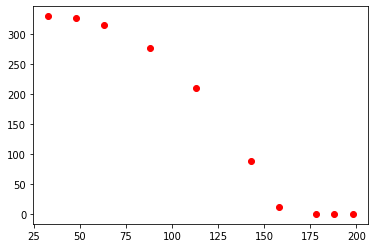

highHIIIIGHHHHHH:  142.0
rewaRD::  -100
returned state: [198.]
observation space:  (11,)
stepping:  0
ACTION            :  3
curtemp:  213.0
Temperature:  [ 33.  48.  63.  88. 113. 143. 158. 178. 188. 198. 213.]
Intensity:  [3.29966436e+02 3.26472537e+02 3.15896520e+02 2.77335541e+02
 2.09855653e+02 8.87918924e+01 1.14655906e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 151.8800898898078
THE JT RESULT {X0}: 0.4000014308452705
THE NF RESULT {X1}: 227.88874064846243
chisqds:  21.798255927830773
BUT ARE WE SURE?: 0.732437022272869


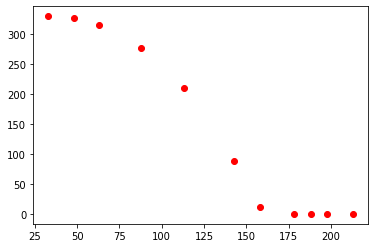

highHIIIIGHHHHHH:  127.0
rewaRD::  -100
returned state: [213.]
observation space:  (12,)


In [8]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [ ]:
from stable_baselines import PPO2, A2C
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1) #retrieve?

Train a new model.

In [ ]:
model = PPO2('MlpPolicy', env, verbose=1).learn(15000)

In [ ]:
model.save("models/")

Restart the training from a saved model.

In [ ]:
model = PPO2.load("models/3245_first_attempt", env)  #if needed, instatiate env above
model = model.learn(500)

Test the trained agent.

In [ ]:
from stable_baselines import PPO2, A2C
from stable_baselines.common.cmd_util import make_vec_env

model = PPO2.load("models/3245_first_attempt") #if you're 'playing' a saved model

env = OrderEnv() 
env.setTn(130)
# wrap it
env = make_vec_env(lambda: env, n_envs=1) 

obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  if done:
    print("Goal reached!", "reward=", reward)
    break

Graph the results of the training time.

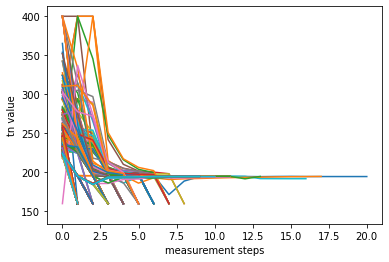

convergence for tn


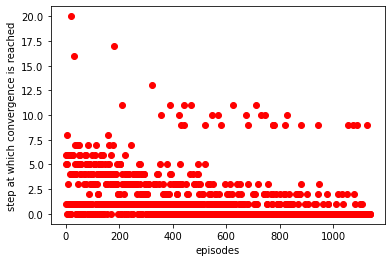

convergence for nf


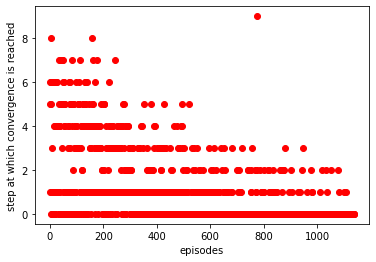

convergence for jt


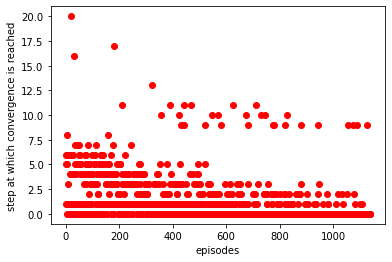

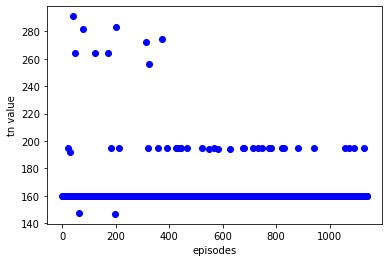

final nfs


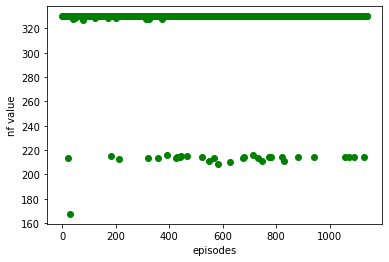

final jts


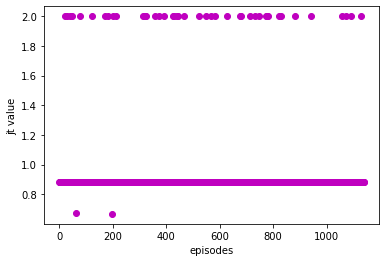

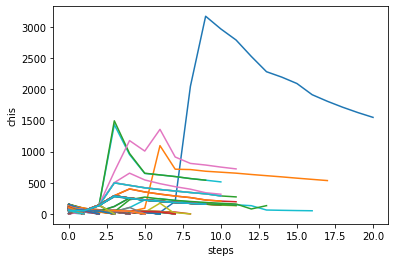

rewards at the end of the episode


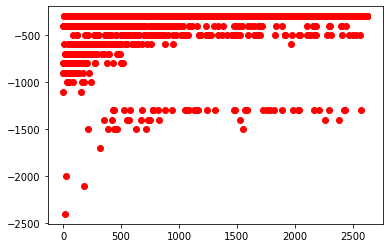

In [ ]:
numTrials = 1140

endParams = [[] for i in range(numTrials)]
data = [[] for i in range(numTrials)]
chis = [[] for i in range(numTrials)]
nfs = [[] for i in range(numTrials)]
jts = [[] for i in range(numTrials)]
endtns = []
endnfs = []
endjts = []
tn = 160
nf = 216
jt = .2
convergs_tn = []
convergs_nf = []
convergs_jt = []
imagestore = "logs/"
logstore = "logs/"

for i in range(1,numTrials+1):
    data[i-1] = np.loadtxt(logstore +  "temps/tnLog-" + str(i) + ".npy")
    chis[i-1] = np.loadtxt(logstore + "chis/chiLog-" + str(i) + ".npy")
    nfs[i-1] = np.loadtxt(logstore + "nf/nfLog-" + str(i) + ".npy")
    jts[i-1] = np.loadtxt(logstore + "jt/jtLog-" + str(i) + ".npy")

#plot each episode tn track, process ending values for plotting below
for i in range (0, len(data)): 
    j = 0
    try: 
      while j < len(data[i]) - 1 and data[i][j] > tn + 0.1 or data[i][j] < tn - 0.1:
        j += 1
    except: 
      j = 0
    
    w = 0
    try: 
      while w < len(nfs[i]) - 1 and nfs[i][w] > nf + 0.1 or nfs[i][w] < nf - 0.1:
        w += 1
    except: 
      w = 0
    
    k = 0
    try: 
      while k < len(jts[i]) - 1 and jts[i][k] > jt + 0.1 or jts[i][k] < jt - 0.1:
        k += 1
    except: 
      k = 0
    
    convergs_tn.append(j)
    convergs_nf.append(w)
    convergs_jt.append(k)

    plt.plot(data[i], label = str(i))

    try:
      value = data[i][-1]
    except:
      value = data[i]
    try:
      nf = nfs[i][-1]
    except:
      nf = nfs[i]
    try:
      jt = jts[i][-1]
    except:
      jt = jts[i]

    #print(value)
    endtns.append(value)
    endnfs.append(nf)
    endjts.append(jt)
    #print(endtns)

plt.xlabel("measurement steps")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "tns.png")
plt.close()

print("convergence for tn")
plt.plot(convergs_tn, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
plt.savefig(imagestore + 'convergs_tn.png')

print("convergence for nf")
plt.plot(convergs_nf, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
plt.savefig(imagestore + 'convergs_nf.png')

print("convergence for jt")
plt.plot(convergs_jt, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
plt.savefig(imagestore + 'convergs_jt.png')

#actually plot final tn values for each episode
plt.plot(endtns, 'bo')
plt.xlabel("episodes")
plt.ylabel("tn value")
plt.show()
plt.savefig(imagestore + "endtns.png")
plt.close()

print("final nfs")
plt.plot(endnfs, 'go')
plt.xlabel("episodes")
plt.ylabel("nf value")
plt.show()
plt.savefig(imagestore + "endnfs.png")
plt.close()

print("final jts")
plt.plot(endjts, 'mo')
plt.xlabel("episodes")
plt.ylabel("jt value")
plt.show()
plt.savefig(imagestore + "endjts.png")
plt.close()

#track chisq values through the episode
for i in range (0, len(chis)):
  plt.plot(chis[i], label = str(i))

plt.xlabel("steps")
plt.ylabel("chis")
plt.show()
plt.close()


print("rewards at the end of the episode")
rewards = np.loadtxt('logs/runrewards.npy')
plt.plot(rewards, 'ro')
plt.show()
plt.close()


Test how a classical fitter works.

temperature:  [  3   7  11  15  19  23  27  31  35  39  43  47  51  55  59  63  67  71
  75  79  83  87  91  95  99 103 107 111 115 119 123 127 131 135 139 143
 147 151 155 159 163 167 171 175 179 183 187 191 195 199 203 207 211 215
 219 223 227 231 235 239 243 247 251 255 259 263 267 271 275 279 283 287
 291 295 299]
Intensity:  [3.30300000e+02 3.30300000e+02 3.30300000e+02 3.30299968e+02
 3.30298873e+02 3.30288400e+02 3.30240148e+02 3.30097540e+02
 3.29780585e+02 3.29198527e+02 3.28262096e+02 3.26891299e+02
 3.25018669e+02 3.22589434e+02 3.19560107e+02 3.15896520e+02
 3.11571865e+02 3.06564979e+02 3.00858961e+02 2.94440090e+02
 2.87297081e+02 2.79420348e+02 2.70801736e+02 2.61434116e+02
 2.51311176e+02 2.40427213e+02 2.28777201e+02 2.16356427e+02
 2.03160611e+02 1.89185814e+02 1.74428400e+02 1.58884980e+02
 1.42552440e+02 1.25427847e+02 1.07508512e+02 8.87918924e+01
 6.92756680e+01 4.89576161e+01 2.78357095e+01 5.90802675e+00
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-

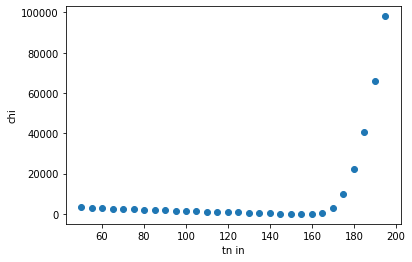

[160.]


In [ ]:
p=[.885,330,.3]
T=np.arange(3, 300, 4)
#T = np.array([14.5, 15])
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 160,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Jt = p[0], Nf = p[1], Bk = p[2])
M.Tn.range(10,400)

x, dx, chisq, params = OrderMethods.fit(M)
print(x)

fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

plt.errorbar(T, I, error)
plt.plot(T, fitI,'ro', markersize = 2)
plt.xlabel("Temperature")
plt.ylabel("Intensity") 
plt.close()